# What Defines a Legendary Pokémon?

![All legendary Pokémon](all-legendary-pokemon-real.png)

What does it mean to be a legendary pokémon? Is its size, weight, or just an arbitrary choice by its creators? In this notebook, I will try to find insights with data across all Pokédex to answer this question, and also train a clustering algorithm to detect **anomalies** in our data, and find the **real legendary pokémons** (spoiler: Gyarados is one of them 🥰)

### Dependencies

In [129]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sklearn
import os
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"

### Reading Data

In [130]:
df = pd.read_csv('data/pokemon.csv', index_col='pokedex_number')
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,name,percentage_male,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
pokedex_number,,,,,,,,,,,,,,,,,,,,,
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,Bulbasaur,88.1,65,65,45,grass,poison,6.9,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,Ivysaur,88.1,80,80,60,grass,poison,13.0,1,0
3,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,Venusaur,88.1,122,120,80,grass,poison,100.0,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,Charmander,88.1,60,50,65,fire,NaN,8.5,1,0
5,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,Charmeleon,88.1,80,65,80,fire,NaN,19.0,1,0


In [131]:
print("Shape of our dataframe:")
df.shape

Shape of our dataframe:


(801, 40)

Our dataset contains 801 pokémons (one per row) and 40 attributes about each one of them, such as weight, height, number of abilities, etc. Let's now analyze our data.

# Exploratory Data Analysis (EDA)

In [132]:
print("All columns we have: ")
df.columns

All columns we have: 


Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'sp_attack', 'sp_defense',
       'speed', 'type1', 'type2', 'weight_kg', 'generation', 'is_legendary'],
      dtype='object')

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 1 to 801
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

We can divide our columns into these categories:
- Numerical columns (with only numerical values):
    - Against columns: how strong/weak a pokémon is against a certain type
    - Base columns: base stats (such as attack, speed, defense)
    - Other attributes
- Object columns (with only text values)
- Null columns (with at least one NaN value)
Let's analyze each one of these categories

In [134]:
num_cols = list(df.select_dtypes(exclude=['object']).columns)
obj_cols = list(df.select_dtypes(include=['object']).columns)
null_cols = df.columns[df.isnull().any()]

print("Number of numeric columns:", len(num_cols))
print("Number of object columns:", len(obj_cols))
print("Number of null columns:", len(null_cols))

Number of numeric columns: 33
Number of object columns: 7
Number of null columns: 4


## Null Columns

In [135]:
df[null_cols].head()

,height_m,percentage_male,type2,weight_kg
pokedex_number,,,,
1,0.7,88.1,poison,6.9
2,1.0,88.1,poison,13.0
3,2.0,88.1,poison,100.0
4,0.6,88.1,NaN,8.5
5,1.1,88.1,NaN,19.0


In [136]:
df[null_cols].isnull().sum()

height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

To impute our NaN values, we have to think about the best approach for **each** column.
- We have to analyze `height_m` and `weight_kg` to see if we impute by their mean or median;
- Why there are `percentage_male` NaN values? Perhaps these Pokémon don't have a genre?
- There are Pokémon that have only one type, that's why there are so many NaN values for `type2`. We will impute this column with the string "None".

In [137]:
df.type2.fillna("None", inplace=True)

We will find the best approach for each column in analyzing the Object and Numerical Columns.

## Object Columns

In [138]:
df[obj_cols].head()

,abilities,capture_rate,classfication,japanese_name,name,type1,type2
pokedex_number,,,,,,,
1,"['Overgrow', 'Chlorophyll']",45,Seed Pokémon,Fushigidaneフシギダネ,Bulbasaur,grass,poison
2,"['Overgrow', 'Chlorophyll']",45,Seed Pokémon,Fushigisouフシギソウ,Ivysaur,grass,poison
3,"['Overgrow', 'Chlorophyll']",45,Seed Pokémon,Fushigibanaフシギバナ,Venusaur,grass,poison
4,"['Blaze', 'Solar Power']",45,Lizard Pokémon,Hitokageヒトカゲ,Charmander,fire,None
5,"['Blaze', 'Solar Power']",45,Flame Pokémon,Lizardoリザード,Charmeleon,fire,None


This is our dataset with only object columns. There is an error in it - why is `capture_rate` an object column? It has a value '30 (Meteorite)255 (Core)'. Let's replace it with 30.

In [139]:
df.capture_rate = df.capture_rate.replace('30 (Meteorite)255 (Core)', 30)
df.capture_rate = df.capture_rate.astype(int)

Okay, so what about the other columns? What questions can we ask about them?
- `name` and `japanese_name` have a unique value for each pokémon, so we will discard them to find our real legends.
- `abilities` is a list of possible abilities for each pokémon. How many possibilities are there for each one?
- Is `classification` unique for each pokémon?
- What are the differences between the distribution in `type1` and `type2`, and their relationship with legendary pokémon?

In [140]:
obj_cols.remove('name')
obj_cols.remove('japanese_name')

### Type

In [141]:
dict_color_types = {"Water": "rgb(51, 153, 255)",
                    "Normal": "#e0e0d1",
                    "Grass": "#47d147",
                    "Bug": "#669900",
                    "Psychic": "#ff33cc",
                    "Fire": "#ff0000",
                    "Rock": "#ffd24d",
                    "Electric": "#ffff00",
                    "Poison": "#990099",
                    "Ground": "#cc9900",
                    "Dark": "#1a001a",
                    "Fighting": "#ff4000",
                    'Ghost': "#1a001a",
                    'Dragon': "#0033cc",
                    'Steel': "#999966",
                    'Ice': "#00ffff",
                    'Fairy': "#ffccee",
                    'Flying': "#d1e0e0",
                    }   # a dictionary of colors for each type

In [142]:
from plotly.subplots import make_subplots

count_type1 = df.groupby('type1').size().sort_values(ascending=True)
count_type1.index = count_type1.index.map(lambda x: x.capitalize())
count_type2 = df.groupby('type2').size().sort_values(ascending=True)
count_type2.index = count_type2.index.map(lambda x: x.capitalize())

fig = make_subplots(rows=1, cols=2, subplot_titles=("Type 1", "Type 2"),
                    )

for idx, typ in enumerate([count_type1, count_type2]):
    fig.add_trace(go.Bar(y=typ.index, x=typ.values, 
                       text=typ.values, textposition='outside',
                       orientation='h',
                       marker_color=typ.index.map(dict_color_types),
                       name="Type "+str(idx+1),
                       ),
                       row=1, col=idx+1)
    if idx == 1: # update range to show text on bars
        fig.update_xaxes(visible=False, range=[0, 500], row=1, col=idx+1) 
    else:
        fig.update_xaxes(visible=False, range=[0, 130], row=1, col=idx+1)

fig.update_layout(title='Nº of Pokemon Types',
                 template='plotly_white', width=1000, height=600,
                 showlegend=False,
                 margin=dict(l=40, r=10, t=100, b=20),
                 yaxis_title="Type",
                 )

fig.show()

So Water and Normal are the most common primary types, and the most common secondary is none at all, followed by flying. But it's curious, there are only 3 pokémon whose primary type is flying, who are they?

In [143]:
print("Pokémons that have flying as their primary type:")
df[df.type1 == 'flying'][["name", "type1", "type2"]]

Pokémons that have flying as their primary type:


,name,type1,type2
pokedex_number,,,
641,Tornadus,flying,None
714,Noibat,flying,dragon
715,Noivern,flying,dragon


In [144]:
count_type1 = df[df.is_legendary == 1].groupby('type1').size().sort_values(ascending=True)
count_type1.index = count_type1.index.map(lambda x: x.capitalize())
count_type2 = df[df.is_legendary == 1].groupby('type2').size().sort_values(ascending=True)
count_type2.index = count_type2.index.map(lambda x: x.capitalize())

fig = make_subplots(rows=1, cols=2, subplot_titles=("Type 1", "Type 2"),
                    )

for idx, typ in enumerate([count_type1, count_type2]):
    fig.add_trace(go.Bar(y=typ.index, x=typ.values, 
                       text=typ.values, textposition='outside',
                       orientation='h',
                       marker_color=typ.index.map(dict_color_types),
                       name="Type "+str(idx+1),
                       ),
                       row=1, col=idx+1)
    if idx == 1: # update range to show text on bars
        fig.update_xaxes(visible=False, range=[0, 30], row=1, col=idx+1) 
    else:
        fig.update_xaxes(visible=False, range=[0, 30], row=1, col=idx+1)

fig.update_layout(title="Nº of Legendary Pokémon's Types",
                 template='plotly_white', width=1000, height=600,
                 showlegend=False,
                 margin=dict(l=40, r=10, t=100, b=20),
                 yaxis_title="Type",
                 )

fig.show()

Comparing them with ordinal Pokémon, we can see some differences, but also some similarities:
- The most common primary types are Psychic and Dragon for legendary against Water and Normal for non-legendary;
- None and Flying are also the most common secondary types for legendary pokémons!

So, does it `type2` helps us to identify legendary pokémon? Let's plot their distribution:

In [145]:
count_type2 = df.groupby('type2').size().sort_values(ascending=True)
count_type2.index = count_type2.index.map(lambda x: x.capitalize())
count_type2_leg = df[df.is_legendary == 1].groupby('type2').size().sort_values(ascending=True)
count_type2_leg.index = count_type2_leg.index.map(lambda x: x.capitalize())

fig = make_subplots(rows=1, cols=2, subplot_titles=("Non-legendary", "Legendary"),
                    )

for idx, typ in enumerate([count_type2, count_type2_leg]):
    fig.add_trace(go.Bar(y=typ.index, x=typ.values, 
                       text=typ.values, textposition='outside',
                       orientation='h',
                       marker_color=typ.index.map(dict_color_types),
                       name="Type "+str(idx+1),
                       ),
                       row=1, col=idx+1)
    if idx == 1: # update range to show text on bars
        fig.update_xaxes(visible=False, range=[0, 500], row=1, col=idx+1) 
    else:
        fig.update_xaxes(visible=False, range=[0, 500], row=1, col=idx+1)

fig.update_layout(title="Nº of Legendary Pokémon's Types",
                 template='plotly_white', width=1000, height=600,
                 showlegend=False,
                 margin=dict(l=40, r=10, t=100, b=20),
                 yaxis_title="Type",
                 )

fig.show()

We can see that their top-10 most common types are very similar. It's better to ignore this column to train our cluster algorithm, it doesn't aggregate much about pokémon being legends or not.

In [146]:
obj_cols.remove('type2')

### Classification

Like I said earlier, is Classification unique for each poke or not? Let's plot how many pokémon have a classification in common:

In [147]:
fig = df["classfication"].value_counts().hist()
fig.update_layout(title="Classifications in Common",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
                    xaxis_title="nº of Pokémon with the same classification",
                    yaxis_title="nº of Pokémon in this category",
)

We have too many exclusive classifications, so we will also ignore this column. 

In [148]:
obj_cols.remove('classfication')

### Abilities

How many abilities a Pokémon can have?

In [149]:
def len_abilities(l):
    if l[0] != '[':
        return 1
    else:
        l = l.replace("'", "").replace(" ", "").strip('[]').split(',')
        return len(l)

In [150]:
df["n_abilities"] = df.abilities.map(len_abilities)

In [151]:
df.n_abilities.value_counts().plot(kind='bar')
fig.update_layout(title="Nº of Abilities for Pokémon",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
                    xaxis_title="Lenght of possible abilities",
                    yaxis_title="nº of Pokémon",
)

Just like classification, it has too many unique values. Let's remove it.


In [152]:
obj_cols.remove('abilities')
obj_cols.remove('capture_rate')
print("We will use these object columns:", obj_cols)

We will use these object columns: ['type1']


## Numerical Columns

Let's see some basic statistics about them:

In [82]:
df.describe()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,hp,percentage_male,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary,n_abilities,against_dark_ghost
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,781.000000,801.000000,801.000000,801.000000,801.000000
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,...,68.958801,54.524969,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391,2.479401,1.021067
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,...,26.576015,19.055207,32.353826,27.942501,28.907662,109.354766,1.930420,0.282583,0.857256,0.456212
min,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,...,1.000000,0.000000,10.000000,20.000000,5.000000,0.100000,1.000000,0.000000,1.000000,0.250000
25%,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,...,50.000000,50.000000,45.000000,50.000000,45.000000,9.000000,2.000000,0.000000,2.000000,0.750000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,65.000000,50.000000,65.000000,66.000000,65.000000,27.300000,4.000000,0.000000,3.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,80.000000,50.000000,91.000000,90.000000,85.000000,64.800000,5.000000,0.000000,3.000000,1.000000
max,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,255.000000,100.000000,194.000000,230.000000,180.000000,999.900000,7.000000,1.000000,6.000000,4.000000


In [24]:
num_cols = list(df.select_dtypes(exclude=['object']).columns)
num_cols.sort()
len(num_cols)

35

Like I said earlier, we can split our numerical columns in three categories - against, base stats and others.

### Against columns

In [154]:
num_cols_against = num_cols[:18].copy()
print("Against columns:", num_cols_against)

Against columns: ['against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 'against_fight', 'against_fire', 'against_flying', 'against_ghost', 'against_grass', 'against_ground', 'against_ice', 'against_normal', 'against_poison', 'against_psychic', 'against_rock', 'against_steel', 'against_water']


In [26]:
corr = df[num_cols_against].corr()
px.imshow(corr, color_continuous_scale=px.colors.sequential.Plasma)

This heatmap points out an interesting relationship: 0.68 between `against_ghost` and `against_dark`. Let's calculate their mean and join both columns.

In [27]:
def mean_against(x, y):
    return (x+y)/2

In [28]:
df["against_dark_ghost"] = mean_against(df["against_ghost"], df["against_dark"])
num_cols.append("against_dark_ghost")

In [29]:
num_cols.remove("against_dark")
num_cols.remove("against_ghost")

### Base Stats columns

In [155]:
att_cols = ['attack', 'defense', 'hp', 'sp_attack', 'sp_defense', 'speed', 'base_total']
print("Base stats columns:", att_cols)

Base stats columns: ['attack', 'defense', 'hp', 'sp_attack', 'sp_defense', 'speed', 'base_total']


In [32]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=7, cols=1, subplot_titles=("Attack", "Defense", "HP", "Sp. Atk", "Sp. Def", "Speed", "Total"))

for i, col in enumerate(att_cols):
    fig.add_trace(go.Histogram(x=df[col], name=col), row=i+1, col=1)
    
fig.update_layout(width=800, height=800, template='plotly_white', showlegend=False)
fig.update_yaxes(range=[0, 100])
fig.show()

There are some positive outliers in our distributions. Are they legendary?

In [157]:
print("The strongest Pokémon! (including their mega-evolution)")
df[["base_total", "name","is_legendary"]].sort_values("base_total", ascending=False).head(20)

The strongest Pokémon! (including their mega-evolution)


,base_total,name,is_legendary
pokedex_number,,,
150,780,Mewtwo,1
384,780,Rayquaza,1
383,770,Groudon,1
382,770,Kyogre,1
493,720,Arceus,1
718,708,Zygarde,1
381,700,Latios,1
373,700,Salamence,0
248,700,Tyranitar,0


From the top-20 strongest pokémon, 16 of them are legendary!

### Other Numerical Columns

In [159]:
print("Other numerical columns: ",list(set(num_cols[18:]) - set(att_cols)))

Other numerical columns:  ['generation', 'base_egg_steps', 'weight_kg', 'base_happiness', 'is_legendary', 'percentage_male', 'height_m', 'experience_growth']


In [35]:
fig = df.generation.value_counts().plot(kind='bar')
fig.update_layout(title="Nº of Pokémon per Generation",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
                    yaxis_title="Nº of Pokémon",
                    xaxis_title="Generation",
)

In [161]:
fig = df[df.is_legendary == 1].generation.value_counts().plot(kind='bar')
fig.update_layout(title="Nº of Legendary Pokémon per Generation",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
                    yaxis_title="Nº of Pokémon",
                    xaxis_title="Generation",
)

Why do we have more Legendary Pokémon in the newest generations? What about the Old School? We can see a correlation between the nº of legends and generations, but correlation doesn't imply casualization. If we think about it, there should be an equal probability of legendary pokémon in each generation. We won't use this column for predictions.

In [162]:
num_cols.remove("generation")

In [36]:
fig = px.scatter(df, x="weight_kg", y="height_m", facet_col="is_legendary", color="is_legendary",
                 hover_data=dict(is_legendary=False,
                                 ), hover_name="name",)
fig.update_layout(title="Weight vs Height",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
                    yaxis_title="Height (m)",
                    
                    
)
fig.update_xaxes(title_text="Weight (kg)")
fig.update_coloraxes(showscale=False)
fig.show()

We can clearly see there are heavier legendary pokémon than heavier non-legendary. But what about height? 

To approach this question, we have to think about both our samples: we only have 72 legendary pokémon, against 801 non-legendary. If the quantity of taller pokémon legendary and non-legendary appears to be similar, the probability of a legendary pokémon being taller is way bigger than a non-legendary!

In [37]:
df[["weight_kg", "height_m"]].describe()

,weight_kg,height_m
count,781.000000,781.000000
mean,61.378105,1.163892
std,109.354766,1.080326
min,0.100000,0.100000
25%,9.000000,0.600000
50%,27.300000,1.000000
75%,64.800000,1.500000
max,999.900000,14.500000


Given there are some outliers (which are important, so we won't remove them), we will replace NaN values for their median in both columns.

In [164]:
print("Pokémon that don't have a genre:")
df_genre = df[df.percentage_male.isnull()][["name", "is_legendary"]]
df_genre

Pokémon that don't have a genre:


,name,is_legendary
pokedex_number,,
81,Magnemite,0
82,Magneton,0
100,Voltorb,0
101,Electrode,0
120,Staryu,0
...,...,...
797,Celesteela,1
798,Kartana,1
799,Guzzlord,1


How many legendary pokémon don't have a genre?

In [165]:
df_genre.is_legendary.value_counts()

1    63
0    35
Name: is_legendary, dtype: int64

So, pretty much all legendary Pokémon don't have a genre. What are the legend Pokémon that do have?

In [166]:
df_is_legendary = df[df.is_legendary == 1]
print("Legendary pokémon that have a genre:")
df_is_legendary[~df_is_legendary.percentage_male.isnull()][["name", "percentage_male"]]

Legendary pokémon that have a genre:


,name,percentage_male
pokedex_number,,
380,Latias,0.0
381,Latios,100.0
485,Heatran,50.0
488,Cresselia,0.0
641,Tornadus,100.0
642,Thundurus,100.0
645,Landorus,100.0


OK, but why legendary Pokémon don't have a genre? Probably because they are unique in the Pokémon world, so they are whether a non-genre or male or female! (Besides Heatran, if he's unique how can he has 50/50 genre distribution?). Our real legends will also be unique in our new and proper Pokémon Universe, so let's ignore the genre column.

In [167]:
num_cols.remove("percentage_male")

In [41]:
fig = px.box(df, x="is_legendary", y="base_egg_steps")
fig.update_layout(title="Egg Steps Distribution by Legendary Class",
                  template="plotly_white",
                  xaxis_title="Is Legendary?",
                  yaxis_title="Egg Steps")
fig.show()

In [61]:
fig = px.scatter(df, x="base_egg_steps", y="weight_kg", color="is_legendary", hover_data=dict(is_legendary=False,
                                                                                              ), hover_name="name",)
fig.update_layout(title="Egg Steps vs Weight",
                    template="plotly_white",
                    xaxis_title="Egg Steps",
                    yaxis_title="Weight (kg)",
                    showlegend=False)
fig.show()

Just as the genre dilemma, it appears that the egg steps are defined according to whether a Pokémon is legendary or not. Besides 4 legends, all legendary have egg steps >= 20480. The only pokémon in this threshold that isn't legendary is Type: Null and its evolution Silvally, but we already know he is a unique pokémon to obtain in Pokémon Sword and Shield. We will also ignore this column.

In [168]:
num_cols.remove("base_egg_steps")

In [44]:
df[["base_happiness", "capture_rate", "experience_growth"]].describe()

,base_happiness,capture_rate,experience_growth
count,801.000000,801.000000,8.010000e+02
mean,65.362047,98.675406,1.054996e+06
std,19.598948,76.248866,1.602558e+05
min,0.000000,3.000000,6.000000e+05
25%,70.000000,45.000000,1.000000e+06
50%,70.000000,60.000000,1.000000e+06
75%,70.000000,170.000000,1.059860e+06
max,140.000000,255.000000,1.640000e+06


In [45]:
fig = px.scatter(df, "experience_growth", "base_total", color="is_legendary",
                    hover_data=dict(is_legendary=False,
                                                    ), hover_name="name",)
fig.update_layout(title="Experience Growth vs Total",
                    template='plotly_white', width=1000, height=400,
                    showlegend=True,
                    yaxis_title="Base Total",
                    xaxis_title="Experience Growth",
                    
                    
)
fig.show()

Also, besides 1 pokémon, every legendary has the same Experience Growth. We will also ignore this column.

In [169]:
num_cols.remove("experience_growth")

In [46]:
fig = px.scatter(df, "capture_rate", "base_total", color="is_legendary",
                    hover_data=dict(is_legendary=False,
                                                    ), hover_name="name",)
fig.update_layout(title="Capture Rate vs Total",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
                    yaxis_title="Base Total",
                    xaxis_title="Capture Rate",
                    
                    
)
fig.show()

We can see a negative relationship between `Capture Rate` and `Base Total`, and also legendary pokémons are more difficult to capture!

In [170]:
num_cols.remove("is_legendary")
cols = num_cols + obj_cols
X = df[cols]

In [171]:
corr = X.corr()
px.imshow(corr, color_continuous_scale=px.colors.sequential.Plasma)

We can see that every base stats column has a correlation coefficient >= 0.54. We will also remove these columns and only keep `base_total`

In [181]:
for col in att_cols:
    if col != 'base_total':
        num_cols.remove(col)

In [182]:
cols = num_cols + obj_cols
X = df[cols]

Now that we've chosen the appropriate columns that can show us the real legendary Pokémon, let's train our cluster algorithm. But firstly, what is a clustering algorithm?

To understand it, we first have to split Machine Learning into two categories:
- **Supervised Learning**: when our goal is to predict a particular label (or more than one) in a labeled dataset, i.e. to predict whether someone survived or not in the Titanic (we already know who survived or not, we will train our model to predict new instances)
- **Unsupervised Learning**: when we use an unlabelled dataset to find patterns, anomalies, customer segmentation, and other tasks that don't involve predicting a target that already exists in our dataset.

Our current task is an unsupervised learning problem - we will try to find clusters (groups) in our dataset, and the anomalies (outliers) are going to be considered the Real Legendary Pokémon. But how will we do it? We will use a Bayesian Gaussian Mixture Model 🤯🤯

### What is a Bayesian Gaussian Mixture Model?

To explain in a few words, let's explain the Gaussian Mixture Model. It is a clustering algorithm that clusters instances in differents Gaussian Distributions. You can check a more deep explanation in this wonderful article: https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

And what is a Bayesian GMM? It is a variational Bayesian estimation of a GMM, which means that it tries to find the optimal parameters for a GMM. You can check its documentation at: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html

Now, let's train our model!

# Training our Clustering Algorithm

First, let's prepare our data. We will One-Hot Encode our object columns, replace our NaN values in the numerical columns by their median and standardize and scale all our columns before pass them to our model.

In [184]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

prep_pipe = ColumnTransformer([
    ('cat', cat_pipe, obj_cols),
    ('num', num_pipe, num_cols),
])

X_prep = prep_pipe.fit_transform(X)

Now let's create and train our model

In [185]:
from sklearn.mixture import BayesianGaussianMixture

gm = BayesianGaussianMixture(n_components=30, n_init=10, random_state=42)
gm.fit(X_prep)

BayesianGaussianMixture(n_components=30, n_init=10, random_state=42)

In [186]:
np.round(gm.weights_, 2) # the weights of each gaussian distribution

array([0.09, 0.06, 0.05, 0.1 , 0.07, 0.02, 0.04, 0.01, 0.06, 0.01, 0.05,
       0.03, 0.03, 0.01, 0.05, 0.04, 0.01, 0.06, 0.03, 0.04, 0.03, 0.01,
       0.01, 0.01, 0.03, 0.01, 0.  , 0.01, 0.02, 0.01])

In [187]:
gm.converged_ # True if the algorithm converged

True

OK, but how can we detect anomalies? We will localize the 72 instances (number of legendary pokémon) that are in the lowest-density regions, and they, the most different pokémons, the anomalies, are going to be our legends! But first, we have to define a density threshold to find these anomalies.

In [191]:
df.is_legendary.value_counts(normalize=True)

0    0.912609
1    0.087391
Name: is_legendary, dtype: float64

Our density threshold will be 9%, which represents 72 pokémon.

In [192]:
densities = gm.score_samples(X_prep)
density_threshold = np.percentile(densities, 9)
anomalies = np.where(densities < density_threshold)

In [193]:
real_legendary = df.iloc[anomalies].name

In [194]:
def get_poke_image(name, df=df):
    image_path = "data/pokemon_images/{}.png".format(name.lower().replace(" ", "-"))
    return image_path

# The Real Legendary Pokémon!!

Now, the time has come! Who are going to be the real legends? Let's plot all images of our new and fair Pokédex.

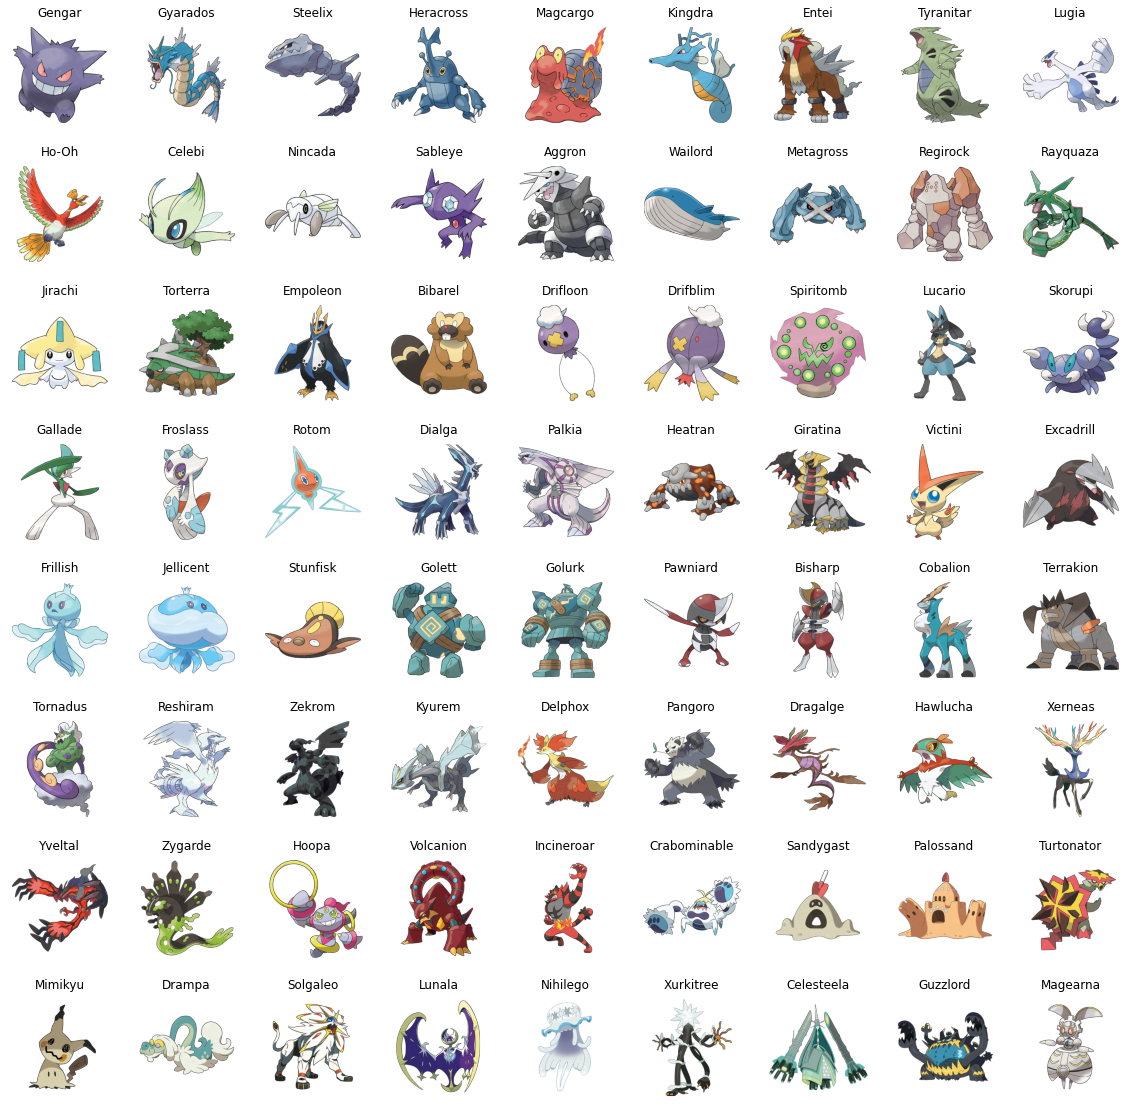

In [196]:
fig, ax = plt.subplots(8, 9, figsize=(20, 20))

for idx, poke in enumerate(real_legendary):
    image_path = get_poke_image(poke)
    image = plt.imread(image_path)
    ax[idx//9, idx%9].imshow(image)
    ax[idx//9, idx%9].axis("off")
    ax[idx//9, idx%9].set_title(poke)

Wow, I can live in a world where Lucario, Gallade, and Wailord are the real deal! Imagine a videogame version with Stunfisk and Bibarel as their Version Legends, I would definitely buy it 😂😂.

As a fan of Pokémon, I had so much fun doing this project! I highly recommend you find some dataset of your interest and study AI having fun with it! 

If you also enjoyed this project, please let me know in the comments, and tell me how can I improve it. Thank you!

![](meme-pokemon-sleep.jpg)